In [4]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from ultralytics import YOLO

In [5]:
import pytest
import hydra
from omegaconf import DictConfig
import os
from ultralytics.data.converter import convert_coco
import shutil
import json

# Convert to COCO to YOLO format

In [6]:
import os
import json
import shutil
import random
from pathlib import Path

# Constants
VAL_SPLIT = 0.2  # 20% of data for validation

def get_dataset_path():
    return Path(os.getcwd()).parent.parent / 'advanced' / 'cv'

def get_output_path():
    return Path(os.getcwd()) / "yolo_dataset"

def split_dataset(image_ids, val_split=0.2):
    random.shuffle(image_ids)
    split_idx = int(len(image_ids) * (1 - val_split))
    return image_ids[:split_idx], image_ids[split_idx:]

def convert_coco_to_yolo(annotations_file, images_dir, output_dir, val_split=0.2):
    print(f"Converting COCO to YOLO format from: {annotations_file}")

    # Load COCO annotations
    with open(annotations_file, 'r') as f:
        coco_data = json.load(f)

    # Build category map and names
    cat_id_to_index = {cat['id']: i for i, cat in enumerate(coco_data['categories'])}
    category_names = [cat['name'] for cat in coco_data['categories']]

    # Map image ID to file name and annotations
    image_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    image_id_to_size = {img['id']: (img['width'], img['height']) for img in coco_data['images']}
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        annotations_by_image.setdefault(ann['image_id'], []).append(ann)

    # Split dataset
    train_ids, val_ids = split_dataset(list(image_id_to_file.keys()), val_split)

    for split, ids in [('train', train_ids), ('val', val_ids)]:
        label_dir = output_dir / 'labels' / split
        image_dir = output_dir / 'images' / split
        os.makedirs(label_dir, exist_ok=True)
        os.makedirs(image_dir, exist_ok=True)

        for img_id in ids:
            file_name = image_id_to_file[img_id]
            width, height = image_id_to_size[img_id]

            # Copy image
            src_img = images_dir / file_name
            dst_img = image_dir / file_name
            shutil.copy(src_img, dst_img)

            # Create YOLO label file
            label_path = label_dir / (Path(file_name).stem + ".txt")
            with open(label_path, 'w') as f:
                for ann in annotations_by_image.get(img_id, []):
                    class_idx = cat_id_to_index[ann['category_id']]
                    x, y, w, h = ann['bbox']
                    cx = (x + w / 2) / width
                    cy = (y + h / 2) / height
                    norm_w = w / width
                    norm_h = h / height
                    f.write(f"{class_idx} {cx} {cy} {norm_w} {norm_h}\n")

    # Save dataset.yaml
    yaml_path = output_dir / "dataset.yaml"
    with open(yaml_path, 'w') as f:
        f.write(f"train: {output_dir / 'images' / 'train'}\n")
        f.write(f"val: {output_dir / 'images' / 'val'}\n")
        f.write(f"names: {category_names}\n")

    print(f"Conversion complete. YOLO dataset saved at: {output_dir}")
    return category_names

In [ ]:
# Execute
dataset_path = get_dataset_path()
output_path = get_output_path()

annotations_file = dataset_path / "annotations.json"
images_dir = dataset_path / "images"

if not annotations_file.exists() or not images_dir.exists():
    print("Missing dataset files.")
else:
    if output_path.exists():
        shutil.rmtree(output_path)
    os.makedirs(output_path, exist_ok=True)
    convert_coco_to_yolo(annotations_file, images_dir, output_path)


# Run Model

In [7]:
# Load YOLO model and train
output_path = get_output_path()
model = YOLO("yolo11_v1.pt")  # Using standard model name
model.train(
    data=str(output_path / "dataset.yaml"),
    epochs=50,  
    imgsz=640,   
    name='yolo11_v2',
    augment=True,
)

New https://pypi.org/project/ultralytics/8.3.139 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.134 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 14918MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/jupyter/til-25-hihi/cv/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11_v1.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11_v22, nbs=64, nms=

train: Scanning /home/jupyter/til-25-hihi/cv/yolo_dataset/labels/train.cache... 16000 images, 595 backgrounds, 0 corrupt: 100%|██████████| 16000/16000 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 423.3±218.6 MB/s, size: 586.0 KB)


val: Scanning /home/jupyter/til-25-hihi/cv/yolo_dataset/labels/val.cache... 4000 images, 152 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo11_v22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolo11_v22
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.22G     0.4793     0.3651      0.841        108        640:  13%|█▎        | 131/1000 [00:58<06:26,  2.25it/s]


KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the validation set
model.val()


# Check data type of output

In [10]:
import cv2

In [16]:
model = YOLO("yolo11_v1.pt")


image 1/1 /home/jupyter/advanced/cv/images/13790.jpg: 384x640 1 fighter jet, 1 truck, 1 van, 69.7ms
Speed: 236.6ms preprocess, 69.7ms inference, 592.9ms postprocess per image at shape (1, 3, 384, 640)


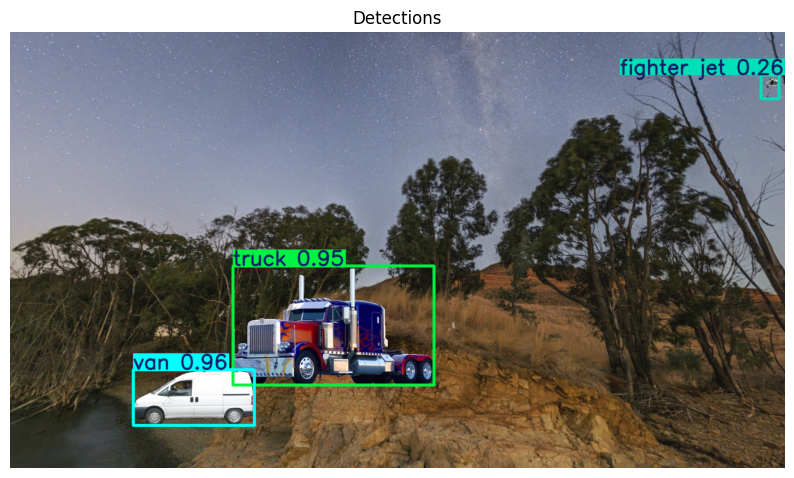

In [12]:
# Predict with the model
results = model(Path(os.getcwd()).parent.parent / "advanced" / "cv" / "images" / "13790.jpg")
#"https://ultralytics.com/images/bus.jpg")  # predict on an image

# Access the results
for result in results:
    xywh = result.boxes.xywh  # center-x, center-y, width, height
    xywhn = result.boxes.xywhn  # normalized
    xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
    xyxyn = result.boxes.xyxyn  # normalized
    names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
    confs = result.boxes.conf  # confidence score of each box
    img_with_boxes = result.plot()  # returns a numpy array (BGR)

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Detections")
    plt.show()


image 1/1 /home/jupyter/advanced/cv/images/4312.jpg: 384x640 2 fighter jets, 2 fighter planes, 1 helicopter, 1 truck, 1 tank, 10.9ms
Speed: 3.4ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


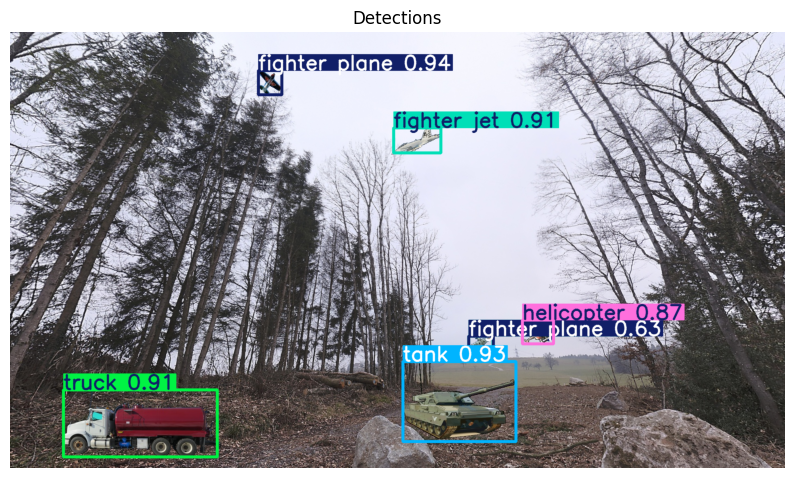

In [13]:
# Predict with the model
results = model(Path(os.getcwd()).parent.parent / "advanced" / "cv" / "images" / "4312.jpg")
#"https://ultralytics.com/images/bus.jpg")  # predict on an image

# Access the results
for result in results:
    xywh = result.boxes.xywh  # center-x, center-y, width, height
    xywhn = result.boxes.xywhn  # normalized
    xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
    xyxyn = result.boxes.xyxyn  # normalized
    names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
    confs = result.boxes.conf  # confidence score of each box
    img_with_boxes = result.plot()  # returns a numpy array (BGR)

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Detections")
    plt.show()


image 1/1 /home/jupyter/til-25-hihi/cv/Screenshot 2025-05-18 at 10.00.14 PM.png: 448x640 2 tanks, 17.4ms
Speed: 3.0ms preprocess, 17.4ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


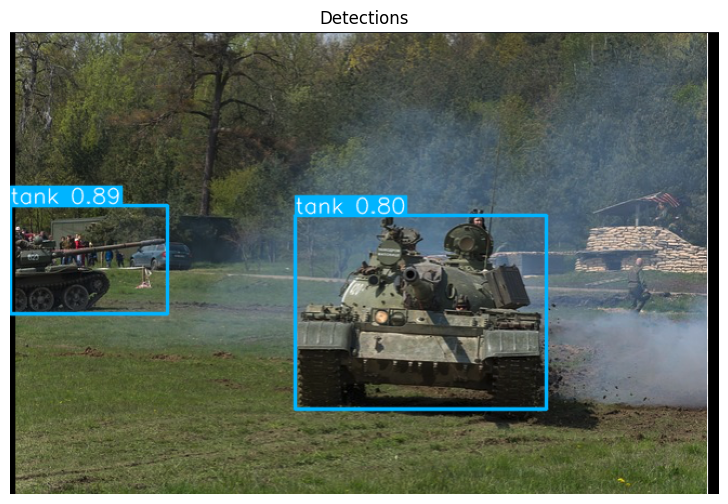

In [19]:
model = YOLO("yolo11_v1.pt")
# Predict with the model
results = model("Screenshot 2025-05-18 at 10.00.14 PM.png")
#"https://ultralytics.com/images/bus.jpg")  # predict on an image

# Access the results
for result in results:
    xywh = result.boxes.xywh  # center-x, center-y, width, height
    xywhn = result.boxes.xywhn  # normalized
    xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
    xyxyn = result.boxes.xyxyn  # normalized
    names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
    confs = result.boxes.conf  # confidence score of each box
    img_with_boxes = result.plot()  # returns a numpy array (BGR)

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Detections")
    plt.show()

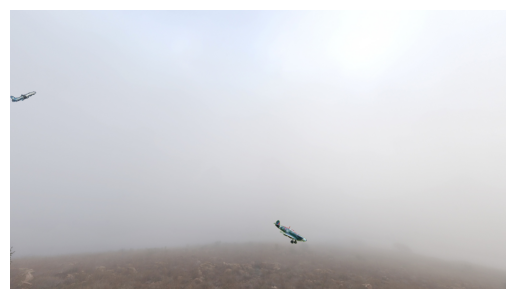

In [20]:
from PIL import Image
import matplotlib.pyplot as plt
path = get_dataset_path()
img = Image.open(path / "images/9146.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()


image 1/1 /home/jupyter/advanced/cv/images/13790.jpg: 384x640 1 fighter jet, 1 truck, 1 van, 55.5ms
Speed: 9.0ms preprocess, 55.5ms inference, 61.9ms postprocess per image at shape (1, 3, 384, 640)


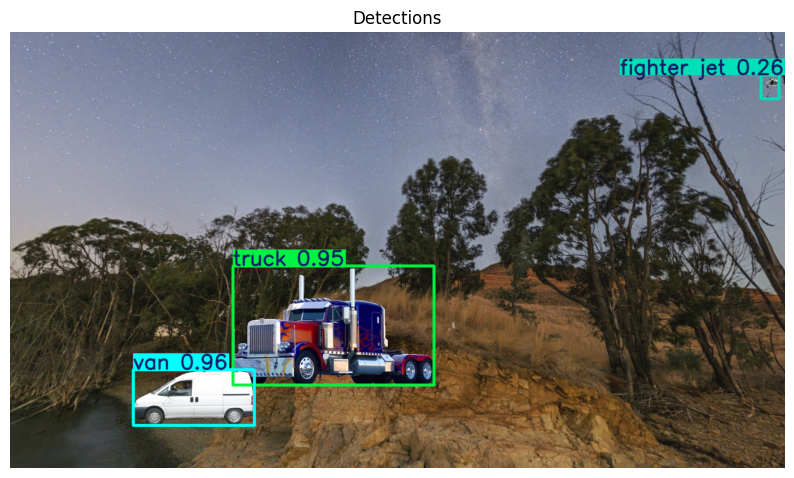

In [22]:
model = YOLO("yolo11_v1.pt")
# Predict with the model
results = model(path / "images/13790.jpg")
#"https://ultralytics.com/images/bus.jpg")  # predict on an image

# Access the results
for result in results:
    xywh = result.boxes.xywh  # center-x, center-y, width, height
    xywhn = result.boxes.xywhn  # normalized
    xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
    xyxyn = result.boxes.xyxyn  # normalized
    names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
    confs = result.boxes.conf  # confidence score of each box
    img_with_boxes = result.plot()  # returns a numpy array (BGR)

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Detections")
    plt.show()


image 1/1 /home/jupyter/advanced/cv/images/9146.jpg: 384x640 1 commercial aircraft, 1 fighter plane, 12.5ms
Speed: 58.9ms preprocess, 12.5ms inference, 508.3ms postprocess per image at shape (1, 3, 384, 640)


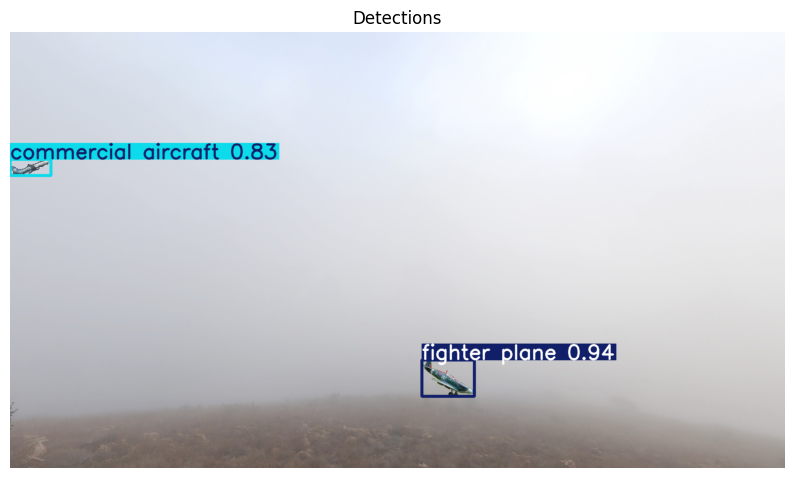

In [23]:
model = YOLO("yolo11_v1.pt")
# Predict with the model
results = model(path / "images/9146.jpg")
#"https://ultralytics.com/images/bus.jpg")  # predict on an image

# Access the results
for result in results:
    xywh = result.boxes.xywh  # center-x, center-y, width, height
    xywhn = result.boxes.xywhn  # normalized
    xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
    xyxyn = result.boxes.xyxyn  # normalized
    names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
    confs = result.boxes.conf  # confidence score of each box
    img_with_boxes = result.plot()  # returns a numpy array (BGR)

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Detections")
    plt.show()


image 1/1 /home/jupyter/advanced/cv/images/8590.jpg: 384x640 1 truck, 1 tank, 14.2ms
Speed: 2.5ms preprocess, 14.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)
tensor([[ 259.8777,  692.0220,  559.6190,  992.6219],
        [ 556.0654,  833.9454,  959.8285, 1076.9517]], device='cuda:0')


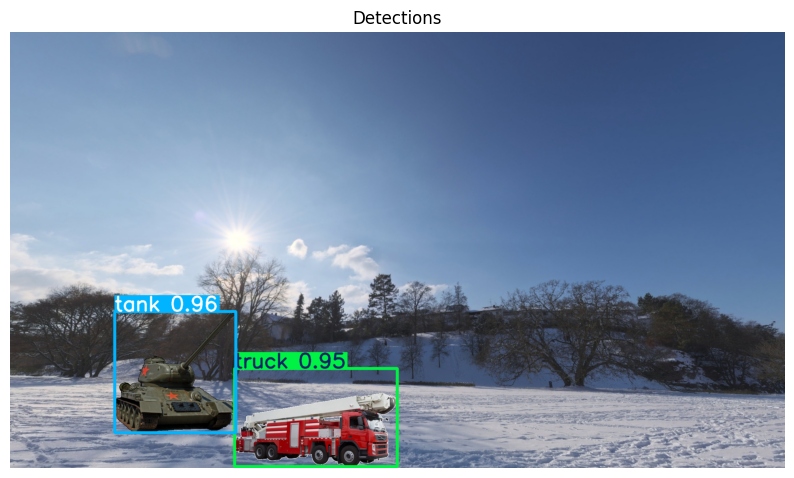

In [33]:
model = YOLO("yolo11_v1.pt")
# Predict with the model
results = model(path / "images/8590.jpg")
#"https://ultralytics.com/images/bus.jpg")  # predict on an image

# Access the results
for result in results:
    xywh = result.boxes.xywh  # center-x, center-y, width, height
    xywhn = result.boxes.xywhn  # normalized
    xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
    print(xyxy)
    xyxyn = result.boxes.xyxyn  # normalized
    names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
    confs = result.boxes.conf  # confidence score of each box
    img_with_boxes = result.plot()  # returns a numpy array (BGR)

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Detections")
    plt.show()
    
# 0: 556.9313812255859
# 1: 879.3356246948242
# 2: 400.5017395019531
# 3: 195.66224670410156


image 1/1 /home/jupyter/advanced/cv/images/4415.jpg: 384x640 1 light aircraft, 1 truck, 1 cargo ship, 61.7ms
Speed: 8.4ms preprocess, 61.7ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)
tensor([[1439.4611,  817.3506, 1897.7278, 1080.0000],
        [  71.7458,  814.6708,  531.5166, 1040.5947],
        [ 197.4966,  573.0602,  252.7771,  644.1840]], device='cuda:0')


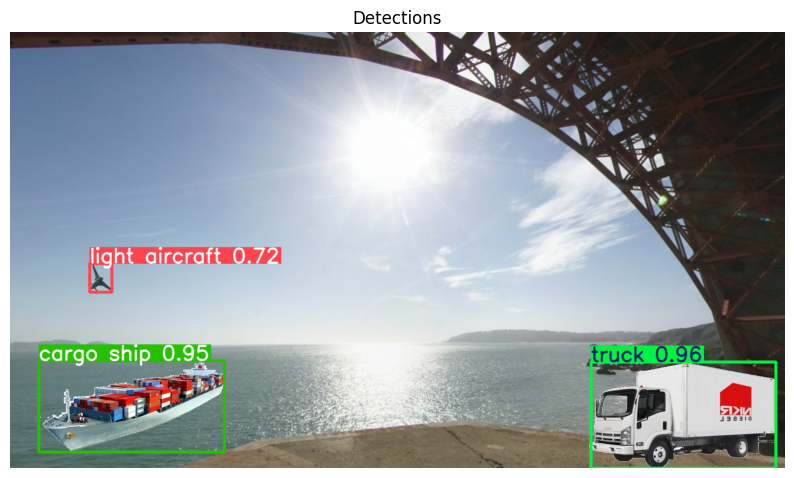

In [34]:
model = YOLO("yolo11_v1.pt")
# Predict with the model
results = model(path / "images/4415.jpg")
#"https://ultralytics.com/images/bus.jpg")  # predict on an image

# Access the results
for result in results:
    xywh = result.boxes.xywh  # center-x, center-y, width, height
    xywhn = result.boxes.xywhn  # normalized
    xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
    print(xyxy)
    xyxyn = result.boxes.xyxyn  # normalized
    names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
    confs = result.boxes.conf  # confidence score of each box
    img_with_boxes = result.plot()  # returns a numpy array (BGR)

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Detections")
    plt.show()
    
# 0: 556.9313812255859
# 1: 879.3356246948242
# 2: 400.5017395019531
# 3: 195.66224670410156

In [31]:
from PIL import Image

# Open the image directly from file
image = Image.open(path / "images/4415.jpg")

# Get original size
width, height = image.size

print(f"Original size of 4415.jpg: Width = {width}, Height = {height}")


Original size of 4415.jpg: Width = 1920, Height = 1080



image 1/1 /home/jupyter/advanced/cv/images/17123.jpg: 384x640 1 commercial aircraft, 1 helicopter, 34.1ms
Speed: 8.0ms preprocess, 34.1ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)
tensor([[  13.2724,  455.2769,   65.3951,  526.3892],
        [1606.9707,  477.7694, 1787.5566,  520.9763]], device='cuda:0')


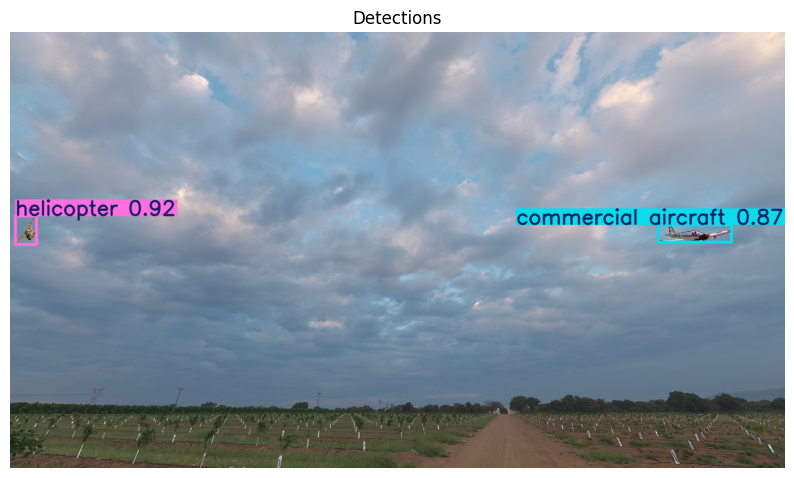

In [35]:
model = YOLO("yolo11_v1.pt")
# Predict with the model
results = model(path / "images/17123.jpg")
#"https://ultralytics.com/images/bus.jpg")  # predict on an image

# Access the results
for result in results:
    xywh = result.boxes.xywh  # center-x, center-y, width, height
    xywhn = result.boxes.xywhn  # normalized
    xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
    print(xyxy)
    xyxyn = result.boxes.xyxyn  # normalized
    names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
    confs = result.boxes.conf  # confidence score of each box
    img_with_boxes = result.plot()  # returns a numpy array (BGR)

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Detections")
    plt.show()
    
# 0: 556.9313812255859
# 1: 879.3356246948242
# 2: 400.5017395019531
# 3: 195.66224670410156